In [1]:
# from __future__ import division
import itertools
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
import math
from sklearn import metrics
from random import randint
from matplotlib import style
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
from env import host, user, password

def get_db_url(database, host=host, user=user, password=password):
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'
url = get_db_url("grocery_db")

In [3]:
sql = """
select *
from grocery_customers
"""

df = pd.read_sql(sql, url, index_col="customer_id")

In [4]:
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
customer_id,,,,,,,,
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


In [5]:

df = df[["Frozen", "Region","Delicassen"]]

In [6]:
np_array = df.values.astype("float32", copy = False)
np_array[0:10]

array([[2.140e+02, 3.000e+00, 1.338e+03],
       [1.762e+03, 3.000e+00, 1.776e+03],
       [2.405e+03, 3.000e+00, 7.844e+03],
       [6.404e+03, 3.000e+00, 1.788e+03],
       [3.915e+03, 3.000e+00, 5.185e+03],
       [6.660e+02, 3.000e+00, 1.451e+03],
       [4.800e+02, 3.000e+00, 5.450e+02],
       [1.669e+03, 3.000e+00, 2.566e+03],
       [4.250e+02, 3.000e+00, 7.500e+02],
       [1.159e+03, 3.000e+00, 2.098e+03]], dtype=float32)

In [7]:
scaler = MinMaxScaler().fit(np_array)
np_array = scaler.transform(np_array)
np_array[0:10]

array([[0.0031063 , 1.        , 0.02784731],
       [0.02854842, 1.        , 0.03698373],
       [0.03911643, 1.        , 0.16355862],
       [0.1048419 , 1.        , 0.03723405],
       [0.063934  , 1.        , 0.10809346],
       [0.01053514, 1.        , 0.03020442],
       [0.00747814, 1.        , 0.0113058 ],
       [0.02701992, 1.        , 0.05346267],
       [0.00657419, 1.        , 0.01558198],
       [0.01863783, 1.        , 0.04370046]], dtype=float32)

In [9]:
dbsc = DBSCAN(eps = .10, min_samples = 20).fit(np_array)

In [10]:
# Now, let's add the scaled value columns back onto the dataframe
columns = list(df.columns)
scaled_columns = ["Scaled_" + column for column in columns]

# Save a copy of the original dataframe
original_df = df.copy()

# Create a dataframe containing the scaled values
scaled_df = pd.DataFrame(np_array, columns=scaled_columns)

# Merge the scaled and non-scaled values into one dataframe
df = df.merge(scaled_df, on=df.index)
df = df.drop(columns=['key_0'])

In [11]:
labels = dbsc.labels_
labels[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [12]:
df['labels'] = labels
df.labels.value_counts()

 0    310
 1     76
 2     43
-1     11
Name: labels, dtype: int64

In [13]:
df[df.labels==-1].head()

,Frozen,Region,Delicassen,Scaled_Frozen,Scaled_Region,Scaled_Delicassen,labels
23,5154,3,16523,0.084298,1.0,0.344597,-1
71,5373,3,14472,0.087897,1.0,0.301815,-1
87,6312,3,14351,0.103330,1.0,0.299291,-1
93,35009,3,2698,0.574979,1.0,0.056216,-1
181,16745,3,8550,0.274801,1.0,0.178285,-1


In [14]:
# Let's look at the descriptive stats for the entire population, the inliers, then the outliers/anomalies
print("Population")
print(df.describe())
print("-------------")
print("Inliers")
print(df[df.labels==0].describe())
print("-------------")
print("Outliers")
print(df[df.labels==-1].describe())

Population
             Frozen      Region    Delicassen  Scaled_Frozen  Scaled_Region  \
count    440.000000  440.000000    440.000000     440.000000     440.000000   
mean    3071.931818    2.543182   1524.870455       0.050078       0.771591   
std     4854.673333    0.774272   2820.105937       0.079789       0.387136   
min       25.000000    1.000000      3.000000       0.000000       0.000000   
25%      742.250000    2.000000    408.250000       0.011788       0.500000   
50%     1526.000000    3.000000    965.500000       0.024670       1.000000   
75%     3554.250000    3.000000   1820.250000       0.058005       1.000000   
max    60869.000000    3.000000  47943.000000       1.000000       1.000000   

       Scaled_Delicassen      labels  
count         440.000000  440.000000  
mean            0.031745    0.343182  
std             0.058826    0.686975  
min             0.000000   -1.000000  
25%             0.008453    0.000000  
50%             0.020077    0.000000  
75% 

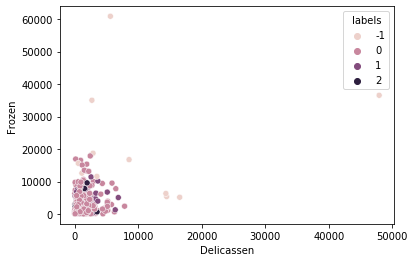

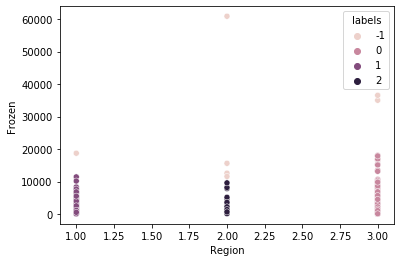

In [15]:
sns.scatterplot(df.Delicassen, df.Frozen, hue=df.labels)
plt.show()

sns.scatterplot(df.Region, df.Frozen, hue=df.labels)
plt.show()